<a href="https://colab.research.google.com/github/alexiawong/Gym-AB-Testing/blob/main/A_B_Testing_Case_Study_Gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
from datetime import datetime, timedelta

## **Scenario:** I am conducting an A/B Test on CTR for a control and experimental button being changed on an app. I want to determine if the new phrasing for the registration would be worth changing to. I am using click through rate as a measure to determine the "success" rate of the new, experimental button.

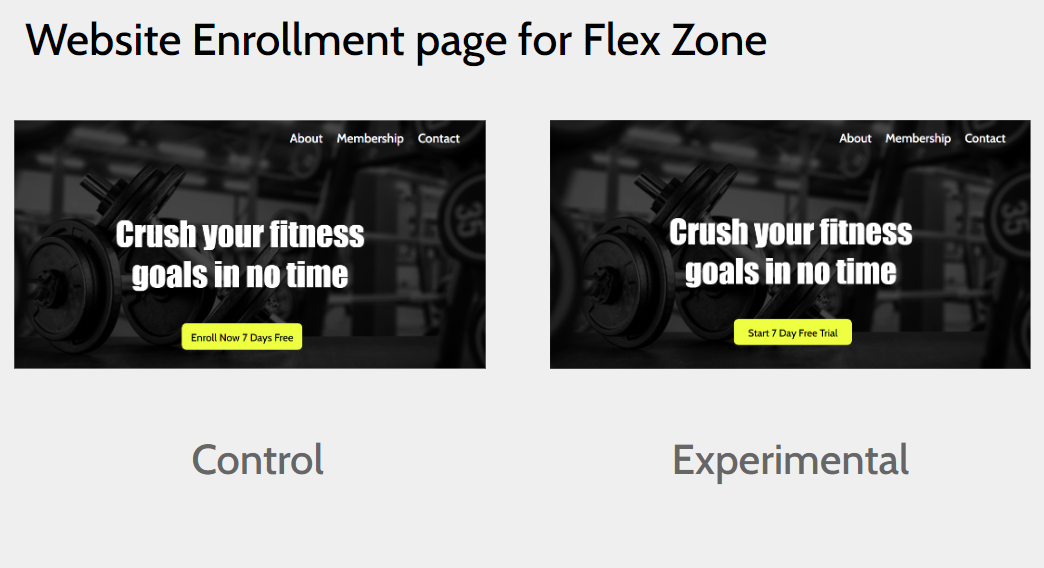


# Loading the CTR Data for A/B Testing

In [2]:
# Load the data from the CSV file
df_ab_test = pd.read_csv('gym_AB_test_data.csv')

# Display first few rows to confirm correct loading
print(df_ab_test.head())
print(df_ab_test.describe())
print(df_ab_test.groupby("group").sum("click"))

   unique id  click group            timestamp
0          1      1   exp  2023-03-12 20:22:56
1          2      0   exp  2023-01-08 08:34:50
2          3      0   exp  2023-04-10 12:58:14
3          4      1   exp  2023-01-08 23:50:18
4          5      0   exp  2023-02-16 13:12:31
          unique id        click
count  20000.000000  20000.00000
mean   10000.500000      0.53085
std     5773.647028      0.49906
min        1.000000      0.00000
25%     5000.750000      0.00000
50%    10000.500000      1.00000
75%    15000.250000      1.00000
max    20000.000000      1.00000
       unique id  click
group                  
con    150005000   6050
exp     50005000   4567


# Create a visual to see the distribution of CTR for the control versus experimental groups

group
con    10000
exp    10000
dtype: int64


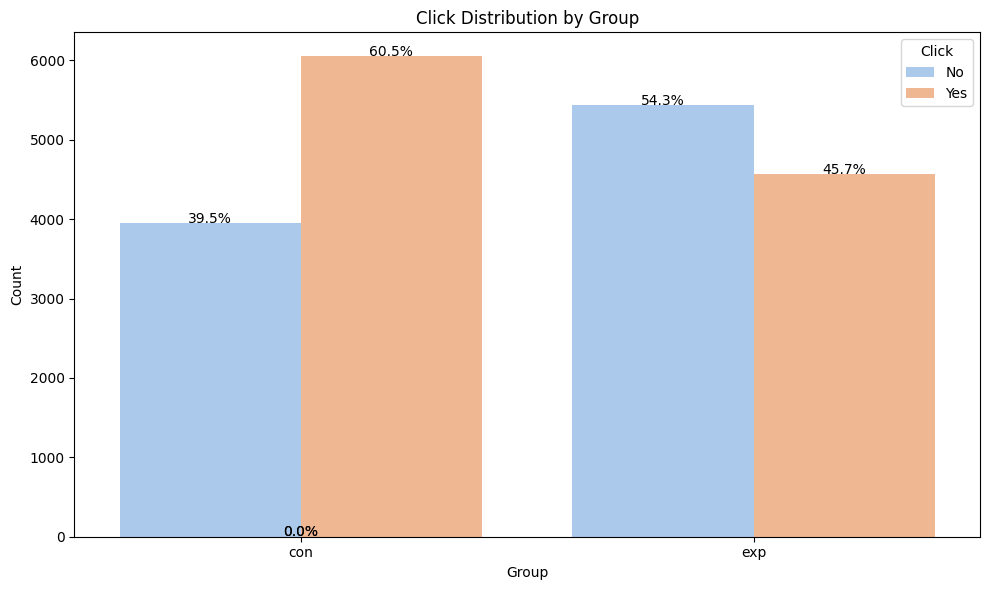

In [3]:
#Calculate percentages and annotate bars
group_counts = df_ab_test.groupby(['group']).size()
print(group_counts)
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=group_click_counts, x='group', y='count', hue='click', palette='pastel')

# Add titles and labels
plt.title('Click Distribution by Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'], handles=ax.get_legend_handles_labels()[0]) #if you don't add handles, the colors won't show on the legend

# Add percentages to the bars
for p in ax.patches:
    height = p.get_height()
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    #This writes in the labels
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

# Set parameters for the model which were discussed with and set by stakeholders.

In [4]:
alpha = 0.05 # 5% type I error probability
print('Alpha: significance level is', alpha)

# Practical significance: is the difference between exp and con different enough?
delta = 0.1
print('Delta: minimum detectable effect is', delta)

Alpha: significance level is 0.05
Delta: minimum detectable effect is 0.1


# Calculate total number of clicks per group

In [5]:
# Number of clicks per group
x_con = df_ab_test[df_ab_test['group'] == 'con']['click'].sum()
x_exp = df_ab_test[df_ab_test['group'] == 'exp']['click'].sum()

# Number of obeservations of control versus experimental
n_con = df_ab_test[df_ab_test['group'] == 'con'].shape[0]
n_exp = df_ab_test[df_ab_test['group'] == 'exp'].shape[0]


print('Clicks for control group:', x_con)
print('Clicks for experimental group:', x_exp)

Clicks for control group: 6050
Clicks for experimental group: 4567


# Calculate Pooled Estimates of Clicks per Group

In [6]:
# Estimates for clicks per group
p_hat_con = x_con / n_con
p_hat_exp = x_exp / n_exp

print('Pooled click estimate for control group:', p_hat_con)
print('Pooled click estimate for experimental group:', p_hat_exp)

# Pooled click estimate
p_hat_pool = (x_con + x_exp) / (n_con + n_exp)
print('Pooled click estimate:', p_hat_pool)

Pooled click estimate for control group: 0.605
Pooled click estimate for experimental group: 0.4567
Pooled click estimate: 0.53085


# Calculate pooled variance and standard error

In [7]:
# Calculate pooled variance
pooled_variance = p_hat_pool * (1 - p_hat_pool) * ((1 / n_con) + (1 / n_exp))

# Calculate standard error
SE = np.sqrt(pooled_variance)

print('Pooled variance:', pooled_variance)
print('Standard error:', SE)


Pooled variance: 4.98096555e-05
Standard error: 0.007057595589150741


# Calculate the test statistic for a 2-Sample Z test

In [8]:
test_stat = (p_hat_exp - p_hat_con) / SE
z_crit = norm.ppf(1 - alpha/2)

print('Test statistic for 2-sample Z-test is:', test_stat)
print('Critical value for 2-sample Z-test is:', z_crit)

Test statistic for 2-sample Z-test is: -21.01282201943868
Critical value for 2-sample Z-test is: 1.959963984540054


# Calculate p-value

In [9]:
p_value = 2 * (norm.sf(abs(test_stat)))

print('p-value for 2-sample Z-test is:', round(p_value,3))

p-value for 2-sample Z-test is: 0.0


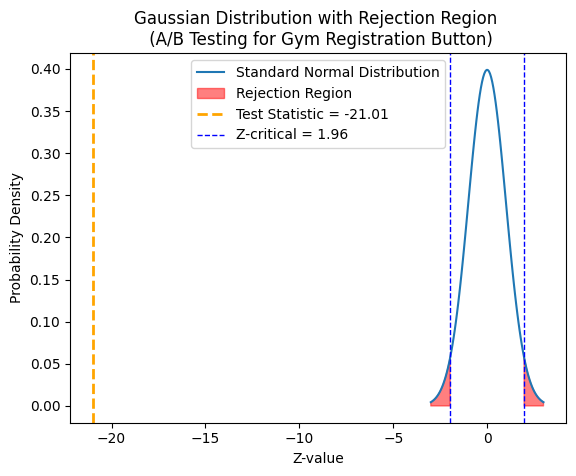

In [11]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > z_crit) | (x < -z_crit), color='red', alpha=0.5, label='Rejection Region')
# Adding Test Statistic
plt.axvline(test_stat, color='orange', linestyle='dashed', linewidth=2, label=f'Test Statistic = {test_stat:.2f}')
# Adding Z-critical values
plt.axvline(z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {z_crit:.2f}')
plt.axvline(-z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for Gym Registration Button)')
plt.legend()
# Show plot
plt.show()

# We can come to a conclusion from our statistical analysis:

In [12]:
# Determine if we can reject or fail to reject a null hypothesis
def interpret_result(p_value, alpha):
    if p_value < alpha:
        print('There is a statistical significance in the data, indicating that the difference between the control and experimental group are not due to chance. This suggests that changes in the experimental group have a real effect in comparison to the control group.')
    else:
        print('There is no statistical significance in the data, suggesting that the observed differences could have occurred through chance. This implies that the changes in the experimental group do not have a substantial effect compared to the control group..')

interpret_result(p_value, alpha)

There is a statistical significance in the data, indicating that the difference between the control and experimental group are not due to chance. This suggests that changes in the experimental group have a real effect in comparison to the control group.


# Calculate a confidence interval to determine practical significance

In [13]:
# Create a confidence interval to calculate practical significance

CI = [round(p_hat_exp - p_hat_con - z_crit * SE, 3), round(p_hat_exp - p_hat_con + z_crit * SE, 3)]
print('Confidence interval is:', CI)

Confidence interval is: [-0.162, -0.134]


In [17]:

def interpret_practical_significance(CI, delta):
    if delta <= abs(CI[0]):
        print("We have practical signifance.")
    else:
        print("We do not have practical significance.")
    if CI[1] < 0:
        print("However, the experiment performed worse than the control group and doesn't justify a change.")
    else:
        print("The experiment performed better than the control group, but not well enough to justify a change.")

interpret_practical_significance(CI, delta)

We have practical signifance.
However, the experiment performed worse than the control group and doesn't justify a change.
